In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio 

TS_DATASET_FOLDER = os.path.join("..", "dataset")
SONG_DATASET_FOLDER = os.path.join(TS_DATASET_FOLDER,"Audio_Song_Actors_01-24")
SPEECH_DATASET_FOLDER = os.path.join(TS_DATASET_FOLDER,"Audio_Speech_Actors_01-24")

def get_actor_files(vc, actor_n):
    fold = SONG_DATASET_FOLDER if vc == "song" else SPEECH_DATASET_FOLDER
    act_fold = f"Actor_{str(actor_n).zfill(2)}"
    fold = os.path.join(fold, act_fold )
    return [os.path.join(fold,f) for f in os.listdir(fold) if f.endswith(".wav")]


CATEGORICAL_FEATURES_NAMES = {
    "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"}, 
    "vocal_channel": {"01": "speech", "02": "song"},
    "emotion": {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : "fearful", "07" : "disgust", "08" : "surprised"},
    "emotional_intensity": {"01" : "normal", "02" : "strong"},
    "statement": {"01" : "kids", "02" : "dogs"},
    "repetition": {"01" : "1st", "02" : "2nd"},
    "actor": {str(i).zfill(2): str(i).zfill(2) for i in range(1, 25)}
}

SAMPLING_RATE = 48_000
DECIMATION_FACTOR = 16

# File import
Files must be downsampled before being saved in memory because they are enormous (200_000 floating point numbers, roughly 0.5 MB)

In [2]:
import sys
from scipy.signal import decimate

df = pd.DataFrame(columns = list(CATEGORICAL_FEATURES_NAMES.keys()) + ["audio_trace", "path"])

for actor_n in tqdm(range(1,25)):
    for f in get_actor_files("song", actor_n):
        segment, sr = librosa.load(f, sr=None)
        segment = decimate(segment, q=DECIMATION_FACTOR)

        categ_values = str(os.path.basename(f)).strip(".wav").split("-")

        row = {attr:val for attr, val in zip(CATEGORICAL_FEATURES_NAMES.keys(), categ_values)}
        row["audio_trace"] = [segment]
        row["path"] = f
        row = pd.DataFrame(row, index = [0])
        df = pd.concat([df,  row], ignore_index=True)

  0%|          | 0/24 [00:00<?, ?it/s]

In [3]:
for column in df.columns:
    df = df.replace(CATEGORICAL_FEATURES_NAMES)

df["sex"] = ["F" if i % 2 == 0 else "M" for i in df["actor"].astype(int)]
df = df.drop(columns = ["modality"])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,audio_trace,path,sex
0,song,angry,normal,kids,1st,01,"[-3.1433858e-06, 1.1001246e-05, -1.3412076e-05...",../dataset/Audio_Song_Actors_01-24/Actor_01/03...,M
1,song,calm,normal,dogs,1st,01,"[-6.406797e-08, 8.9357464e-08, -9.8072945e-08,...",../dataset/Audio_Song_Actors_01-24/Actor_01/03...,M
2,song,angry,strong,kids,1st,01,"[-0.00022916467, 0.0007984184, 5.504581e-05, 4...",../dataset/Audio_Song_Actors_01-24/Actor_01/03...,M
3,song,fearful,strong,kids,1st,01,"[-4.186349e-16, 6.7589873e-16, -8.1260143e-16,...",../dataset/Audio_Song_Actors_01-24/Actor_01/03...,M
4,song,happy,strong,kids,1st,01,"[-6.0235874e-05, 5.593322e-06, 2.0996906e-06, ...",../dataset/Audio_Song_Actors_01-24/Actor_01/03...,M


## Preprocessing

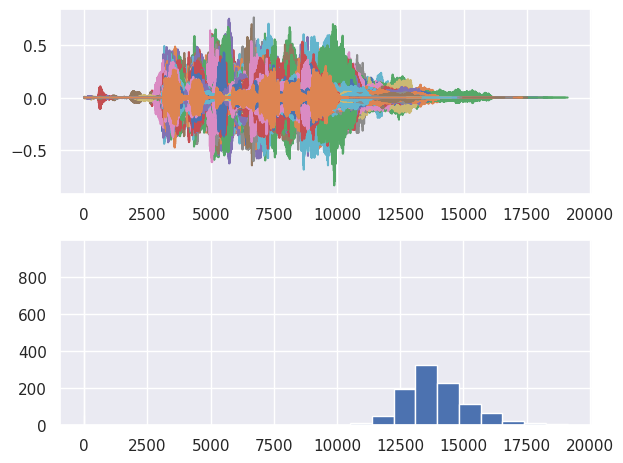

In [4]:
fig, (axtr, axhist) = plt.subplots(2,1)
lenghts = []
means = []
for trace in df.audio_trace:
    lenghts.append(len(trace))
    axtr.plot(trace)
    means.append(np.mean(trace))

axhist.hist(lenghts);
axhist.hist(means);

Now check whether a linear trend is present

In [5]:
from sklearn.linear_model import LinearRegression
coeffs, intercepts = [], []
for trace in df.audio_trace:
    subsamp_trace = decimate(trace, q=8)
    model = LinearRegression()
    model.fit(np.arange(len(subsamp_trace)).reshape(-1,1), subsamp_trace)
    coeffs.append(model.coef_)
    intercepts.append(model.intercept_)
print(np.mean(coeffs), np.mean(intercepts))

1.6202829701451786e-09 -5.02954885203744e-07


In [6]:
from scipy.signal import detrend
detrended_traces = pd.DataFrame(columns=["detrended_trace"])
for trace in df.audio_trace:
    row = dict(detrended_trace=[detrend(trace)])
    row = pd.DataFrame(row, index=[0])
    detrended_traces = pd.concat([detrended_traces, row], ignore_index=True)
df = df.join(detrended_traces)

Now rescale all

In [7]:
normalized_traces = pd.DataFrame(columns = ["normalized_trace"])
for det_trace in df.detrended_trace:
    row = dict(normalized_trace=[(det_trace - np.mean(det_trace))/np.std(det_trace)])
    row = pd.DataFrame(row, index=[0])
    normalized_traces = pd.concat([normalized_traces, row], ignore_index=True)

df = df.join(normalized_traces)

now clean noise using a moving mean filter

In [8]:
try:
    df.drop(columns=["denoised_trace"], inplace=True)
except KeyError as e:
    pass
denoised_traces = pd.DataFrame(columns=["denoised_trace"])
window=20
for norm_trace in df.normalized_trace:
    row = pd.DataFrame([[np.convolve(norm_trace, np.ones(window)/window, mode='valid')]], index=[0], columns=["denoised_trace"])
    denoised_traces = pd.concat([denoised_traces, row], ignore_index=True)
df = df.join(denoised_traces)

now check the difference in terms of perceived audio

In [9]:
Audio(df.audio_trace[58], rate=SAMPLING_RATE/DECIMATION_FACTOR)

In [10]:
Audio(df.denoised_trace[51], rate=SAMPLING_RATE/DECIMATION_FACTOR)

In [11]:
# from tslearn.metrics import dtw 
# ts1 ,ts2 = decimate(df.loc[0, "normalized_trace"], q=1),decimate(df.loc[1, "normalized_trace"], q=1)
# print(dtw(ts1,ts2))

In [12]:
print(f"dataset size is {sys.getsizeof(df)/1e6} MB")

dataset size is 170.273044 MB


In [14]:
df_removed_useless = df.drop(columns=["detrended_trace", "normalized_trace"])
print(f"dataset size is {sys.getsizeof(df_removed_useless)/1e6} MB")

dataset size is 113.568372 MB
